In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import joblib
import os
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# 1. Charger les données
file_path = '../data/processed/transfers_ready_for_model.csv'
if not os.path.exists(file_path):
    print("Erreur : Lance le script de nettoyage (étape 3) d'abord.")
    exit()

df = pd.read_csv(file_path)

In [7]:
# 2. Features & Target 
features = [
    'Age', 'Position_Encoded', 'Valeur_Marchande_Clean',
    'Matchs_22_23', 'Buts_22_23', 'Minutes_22_23'
]
# On ajoute automatiquement les ligues (Ligue_Premier League, etc.)
features.extend([c for c in df.columns if 'Ligue_' in c])

target = 'Prix'

X = df[features]
y = df[target]

print(f"--- DÉMARRAGE DU MODÈLE (Avec Valeur Marchande) ---")
print(f"Nombre de joueurs : {len(df)}")
print(f"Variables utilisées : {len(features)}")

--- DÉMARRAGE DU MODÈLE (Avec Valeur Marchande) ---
Nombre de joueurs : 1116
Variables utilisées : 12


In [8]:
# 3. Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Entraînement
model = RandomForestRegressor(n_estimators=300, random_state=42) # 300 arbres pour être précis
model.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

In [9]:
# 5. Évaluation
predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)



print(f"\n✅ RÉSULTATS :")
print(f"  > Précision (R²) : {r2:.2f} / 1.00 (Doit être > 0.80)")
print(f"  > Erreur Moyenne : {mae:,.0f} €")

# 6. Comparaison : IA vs Transfermarkt
print("\n--- DUEL : TON IA vs TRANSFERMARKT ---")
test_indices = X_test.sample(min(5, len(X_test))).index

compteur_ia_gagne = 0

for i in test_indices:
    nom = df.loc[i, 'Nom']
    vrai_prix = y[i]
    valeur_tm = df.loc[i, 'Valeur_Marchande_Clean']
    
    # Prédiction IA
    prix_ia = model.predict(pd.DataFrame([X.loc[i]], columns=features))[0]
    
    ecart_ia = abs(prix_ia - vrai_prix)
    ecart_tm = abs(valeur_tm - vrai_prix)
    
    print(f"Joueur : {nom}")
    print(f"  💰 Réalité      : {vrai_prix:,.0f} €")
    print(f"  🤖 Ton IA       : {prix_ia:,.0f} € (Ecart: {ecart_ia:,.0f})")
    print(f"  🏷️ Transfermarkt: {valeur_tm:,.0f} € (Ecart: {ecart_tm:,.0f})")
    
    if ecart_ia < ecart_tm:
        print("  🏆 TON IA EST PLUS PRÉCISE !")
        compteur_ia_gagne += 1
    else:
        print("  ❌ Transfermarkt gagne.")
    print("-" * 30)

print(f"\nSCORE FINAL SUR 5 JOUEURS : Ton IA {compteur_ia_gagne} - {5 - compteur_ia_gagne} Transfermarkt")

# 7. Importance des variables
importances = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
importances = importances.sort_values('importance', ascending=False)
print("\n--- CE QUI COMPTE LE PLUS ---")
print(importances.head(5))


✅ RÉSULTATS :
  > Précision (R²) : 0.79 / 1.00 (Doit être > 0.80)
  > Erreur Moyenne : 3,314,512 €

--- DUEL : TON IA vs TRANSFERMARKT ---
Joueur : Moise Kean
  💰 Réalité      : 30,000,000 €
  🤖 Ton IA       : 23,604,333 € (Ecart: 6,395,667)
  🏷️ Transfermarkt: 18,000,000 € (Ecart: 12,000,000)
  🏆 TON IA EST PLUS PRÉCISE !
------------------------------
Joueur : Ibrahima Niane
  💰 Réalité      : 500,000 €
  🤖 Ton IA       : 2,569,103 € (Ecart: 2,069,103)
  🏷️ Transfermarkt: 3,000,000 € (Ecart: 2,500,000)
  🏆 TON IA EST PLUS PRÉCISE !
------------------------------
Joueur : Gabriel Pereira
  💰 Réalité      : 10,000,000 €
  🤖 Ton IA       : 6,240,300 € (Ecart: 3,759,700)
  🏷️ Transfermarkt: 5,000,000 € (Ecart: 5,000,000)
  🏆 TON IA EST PLUS PRÉCISE !
------------------------------
Joueur : Maximiliano Caufriez
  💰 Réalité      : 3,500,000 €
  🤖 Ton IA       : 2,518,377 € (Ecart: 981,623)
  🏷️ Transfermarkt: 2,500,000 € (Ecart: 1,000,000)
  🏆 TON IA EST PLUS PRÉCISE !
-------------------

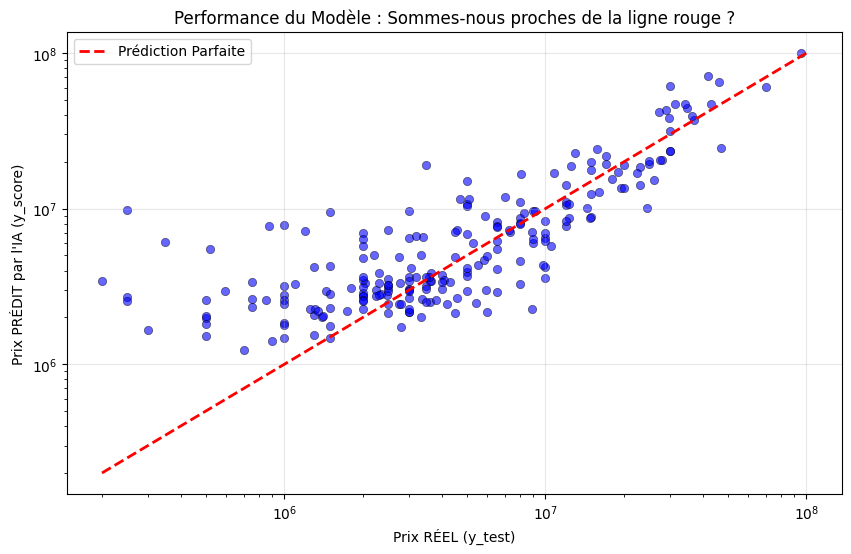

In [10]:
# On reprend tes prédictions
predictions = model.predict(X_test)

# Création du graphique
plt.figure(figsize=(10, 6))

# 1. Le Nuage de points
sns.scatterplot(x=y_test, y=predictions, alpha=0.6, color='blue', edgecolor='k')

# 2. La ligne rouge "parfaite" (Si tout était parfait, tous les points seraient dessus)
# On prend le max et le min pour tracer la diagonale
max_val = max(y_test.max(), predictions.max())
min_val = min(y_test.min(), predictions.min())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='Prédiction Parfaite')

plt.xlabel('Prix RÉEL (y_test)')
plt.ylabel('Prix PRÉDIT par l\'IA (y_score)') # Ici ton "y_score" c'est ta prédiction
plt.title('Performance du Modèle : Sommes-nous proches de la ligne rouge ?')
plt.legend()
plt.grid(True, alpha=0.3)

# Astuce d'affichage pour les grands nombres (Millions)
plt.xscale('log') # Optionnel : Echelle logarithmique si tu as de gros écarts
plt.yscale('log')

plt.show()